<a href="https://colab.research.google.com/github/ashioyajotham/Daily-ML/blob/main/PPOwithJAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actor-Critic Architectures

Proximal Policy Optimization is categorized within the policy gradient family of algorithms, a subset of which includes actor-critic methods. The designation `actor-critic` reflects the dual components of the model:

The actor network creates a distribution over actions given the current state of the environment and returns an action sampled from this distribution. Here, the actor network comprises three dense layers separated by two activation layers (either ReLU or hyperbolic tangeant) and a final categorical layer applying the softmax function to the computed distribution.
The critic network estimates the value function of the current state, in other words, how good a particular action is at a given time. Its architecture is almost identical to the actor network, except for the final softmax layer. Indeed, the critic network doesn’t apply any activation function to the final dense layer outputs as it performs a regression task.

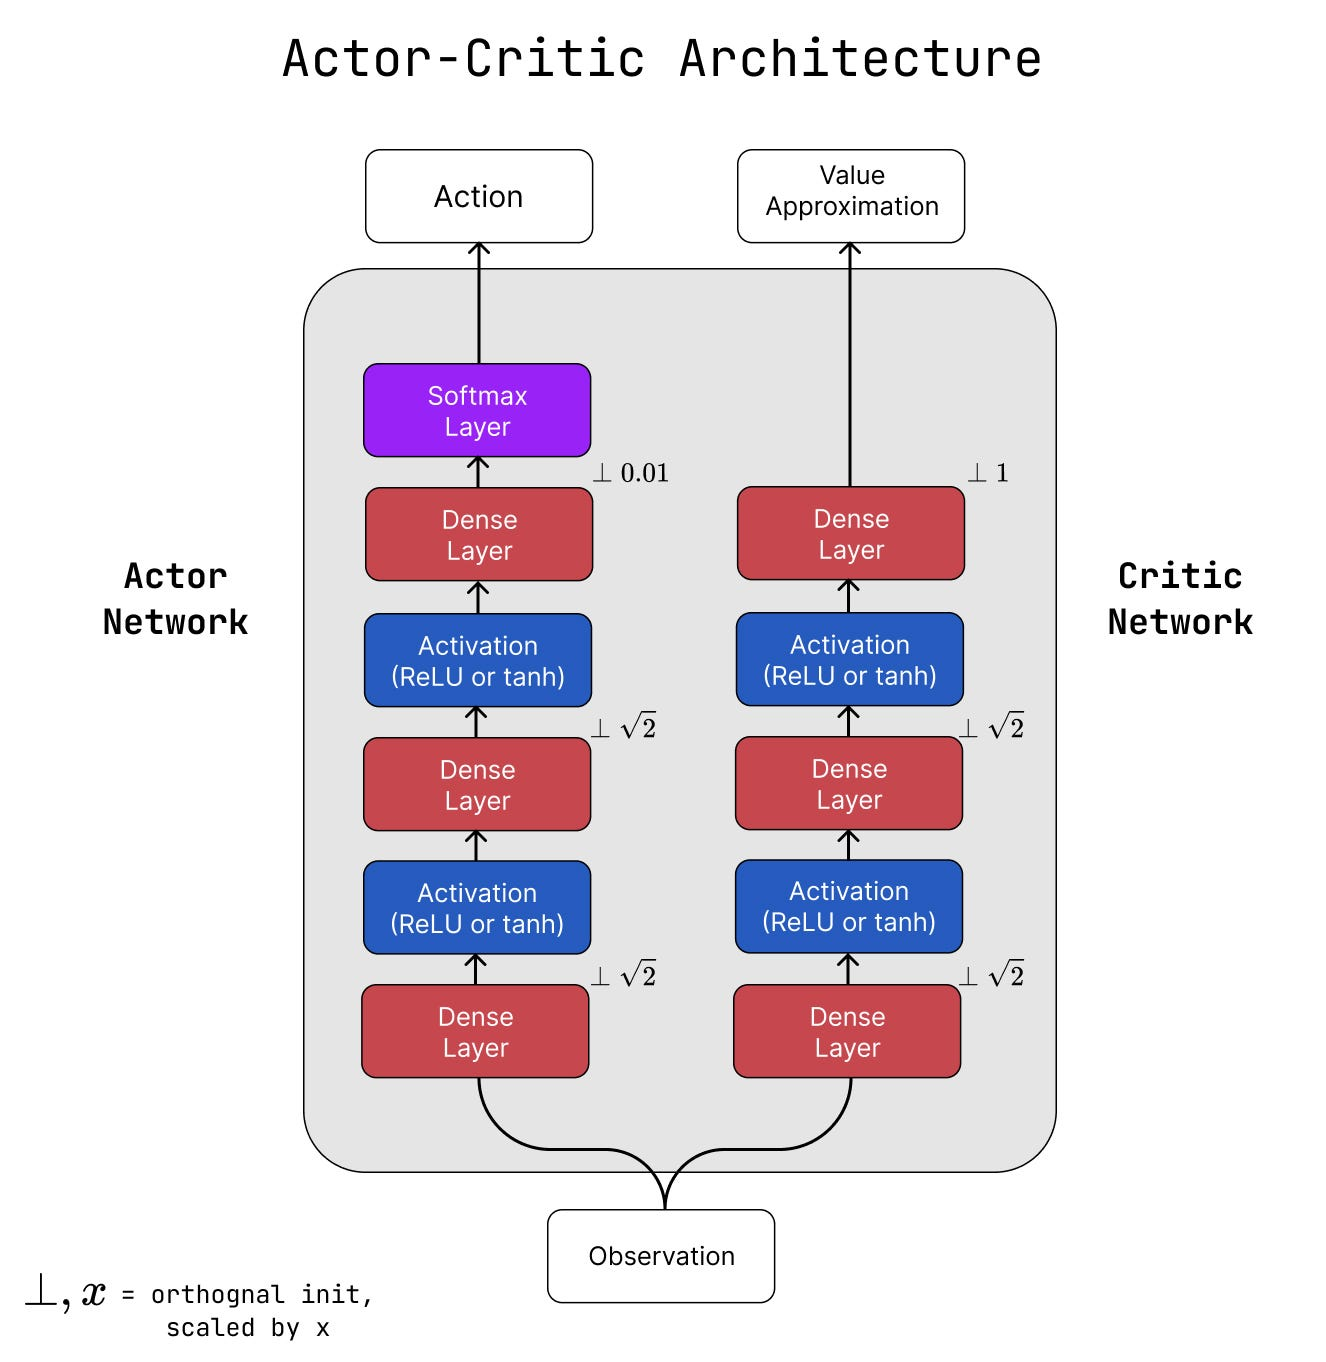

In [ ]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import distrax
from typing import Sequence
from flax.linen.initializers import constant, orthogonal
import numpy as np

class ActorCritic(nn.Module):
  """Actor Critic Network."""
  action_dim: Sequence[int] # Dimension of the action space
  activation: str="tanh" # Activation function to use

  @nn.compact
  def __call__(self, x):
    """Defines the forward pass of the Actor Critic Network."""
    # Determine activation function based on the 'activation' parameter
    if self.activation == 'relu':
      activation = nn.relu
    else:
      activation = nn.tanh

    # actor network
    # First dense layer for the actor network
    actor_mean = nn.Dense(
        64, kernel_init = orthogonal(np.sqrt(2)), bias_init = constant(0.0)
    )(x)
    actor_mean = activation(actor_mean) # Apply activation function

    # Second dense layer for the actor network
    actor_mean = nn.Dense(
        64, kernel_init = orthogonal(np.sqrt(2)), bias_init = constant(0.0)
    )(actor_mean)

    actor_mean = activation(actor_mean) # Apply activation function
    # Output dense layer for the actor network, producing logits for the action distribution
    actor_mean = nn.Dense(
        self.action_dim, kernel_init = orthogonal(0.01), bias_init = constant(0.0)
    )(actor_mean)

    # Create a categorical distribution over the action space using the logits
    pi = distrax.Categorical(logits=actor_mean) #Softmax layer


    # critic network
    # First dense layer for the critic network
    critic = nn.Dense(
        64, kernel_init = orthogonal(np.sqrt(2)), bias_init = constant(0.0) # Corrected bias initialization
    )(x)
    critic = activation(critic) # Apply activation function
    # Second dense layer for the critic network
    critic = nn.Dense(
        64, kernel_init = orthogonal(np.sqrt(2)), bias_init = constant(0.0) # Corrected bias initialization
    )(critic)
    # Output dense layer for the critic network, producing the value estimate
    critic = nn.Dense(1, kernel_init = orthogonal(1.0), bias_init = constant(0.0))( # Corrected bias initialization
        critic
    )
    # Squeeze the output to remove the last dimension and return the action distribution and value estimate
    return pi, jnp.squeeze(critic, axis=-1)

## Training Loop

In [ ]:
def scan(f, init, xs, length=None):
  """Example provided in the JAX documentation"""
  if xs is None:
    xs = [None] * length

  carry = init
  ys = []
  for x in xs:
    # apply function to current state and element x
    carry, y = f(carry, x)
    ys.append(y)
  return carry, np.stack(ys)

### 1. Trajectory Collection
The trajectory collection block consists of a `step` function scanned across N iterations. This step function successively:

* Selects an action using the actor network
* Steps the environment
* Stores transition data in a transition tuple
* Stores the model parameters, the environment state, the current observation, and rng keys in a runner_state tuple

Returns `runner_state` and `transition`
Scanning this function returns the latest runner_state and traj_batch, an array of transition tuples. In practice, transitions are collected from multiple environments in parallel for efficiency as indicated by the use of jax.vmap

In [ ]:
def _env_step(runner_state, unused):
  """
  Steps the environment across ``NUM_ENVS``.
  Returns the updated runner state and transition tuple
  """
  train_state, env_state, last_obs, rng = runner_state

  # action state
  rng, _rng = jax.random.split(rng)
  # here obs has shape (obs, n_env)
  # => pi contains n_env probability distributions
  pi, value = network.apply(train_state.params last_obs)
  actions = pi.sample(seed=_rng)
  log_prob = pi.log_prob(actions)

  # step
  rng, _rng = jax.random.split(rng)
  rng_step = jax.random.split(_rng, config["NUM_ENVS"])
  obsv, env_state, reward, done, info = jax.vmap(
      env.step, in_axes = (0, 0, 0, None)
  )(rng_step, env_state, actions, env_params)

  # collecting data
  transition = Transition(
      done, actions, value, reward, log_prob, last_obs, info
  )
  runner_state = (train_state, env_state, obsv, rng)
  return runner_state, transition

  # scanning the _env_step function across NUM_STEPS iterations
  runner_state, traj_batch = jax.lax.scan(
      _env_step, runner_state, None, config["NUM_STEPS"]
  )

### 2. Generalized Advantage Estimation


In [ ]:
_, last_val = network.apply(train_state.params, last_obs)

def _calculate_gae(traj_batch, last_val):
  """
  Compute the Generalized Advantage Estimate of a trajectory batch
  """
  def _get_advantages(gae_and_next_value, transition):
    """
    Computes the GAE at time t.
    Uses `